In [1]:
from modules.base import *

- LongTerm 메모리로 개인정보 넣음
- 대화내용 요약 및 오래된 state 정리

In [3]:
LIMIT_LENGTH = 12 # 대화기록이 특정길이 넘어갈경우 일부삭제

In [4]:
prompt_config = ConfigDict()
prompt_config.answer_prompt = """당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
{memory}

[이전 대화요약]:
{summary}"""

prompt_config.create_memory_prompt ="""당신은 사용자의 응답을 개인화하기 위해 사용자에 대한 정보를 수집하고 있습니다.

[현재 사용자 정보]
{memory}

지침:
1. 아래의 채팅 기록을 주의 깊게 검토하세요.
2. 사용자에 대한 새로운 정보를 식별하세요. 예를 들면:
   - 개인 정보 (이름, 위치 등)
   - 선호 사항 (좋아하는 것, 싫어하는 것 등)
   - 관심사와 취미
   - 과거 경험
   - 목표나 미래 계획   
   - 질문 유형
   - 답변 선호 사항
3. 새로운 정보를 기존 메모리와 병합하세요.
4. 메모리는 명확한 불릿 리스트 형식으로 작성하세요.
5. 새로운 정보가 기존 메모리와 충돌할 경우, 가장 최근 정보를 유지하세요.
6. 만약 새로운 정보가 없다면 [현재 사용자 정보] 내용을 그대로 출력하세요.
7. 기존 정보를 유지할경우 [현재 사용자 정보] 내용을 그대로 출력하세요.

기억하세요: 사용자가 직접적으로 언급한 사실적인 정보만 포함해야 합니다. 추측이나 추론을 하지 마세요.

아래의 채팅 기록을 바탕으로 사용자 정보를 업데이트하세요:

출력 양식은 반드시 아래를 따르세요.

- 정보 종류 : 정보 내용
- 정보 종류 : 정보 내용
...
"""

prompt_config.summary_prompt = """위 내용들은 사용자와 챗봇의 대화 내용입니다. 사용자와 챗봇이 어떤 대화를 주고 받았는지 내용을 요약해보세요.

지침:
1. 이름, 학업, 취미, 음식, 인적사항 등 사용자의 성향 및 특징을 파악할 수 있는 정보는 요약할 필요없습니다.
2. 개인정보에 대한 대화만 있을 경우 요약하지 않아도 됩니다.
3. 요약할 내용이 없을 경우 빈 문자열을 출력하세요.

출력 양식은 반드시 아래를 따르세요.

- 대화 내용 1
- 대화 내용 2
...
"""
prompt_config.summary_update_prompt = """위 내용들은 사용자와 챗봇의 대화 내용입니다. 사용자와 챗봇이 어떤 대화를 주고 받았는지 내용을 요약해보세요.

[이전 대화요약]
{summary}

지침:
1. [이전 대화요약]을 주의 깊게 검토하세요.
2. 새로운 정보를 [이전 대화요약]과 병합하세요.
3. 새로운 정보가 [이전 대화요약]과 충돌할 경우, 가장 최근 정보를 유지하세요.
4. 만약 새로운 정보가 없다면 [이전 대화요약] 내용을 그대로 출력하세요.

출력 양식은 반드시 아래를 따르세요.

- 대화 내용 1
- 대화 내용 2
...
"""

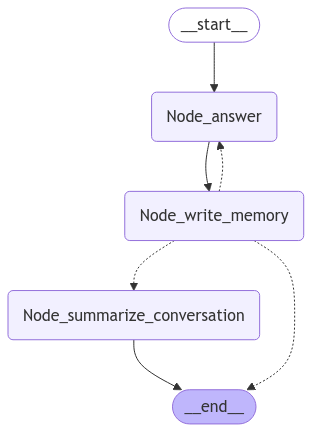

In [5]:
class State(MessagesState):
    summary: str

@trace_function(enable_print=False)
def node_answer(state: State, 
                config: RunnableConfig,
                store: BaseStore):
    
    # 요약 부문
    summary = state.get("summary", "")
    namespace = ("memories", config["configurable"]["user_id"])
    key = "chat_user_memory"
    memory = _get_memory(namespace=namespace, 
                         key=key, 
                         store=store)
    system_message = prompt_config.answer_prompt.format(memory=memory, summary=summary)
    prompt = [SystemMessage(content=system_message)] + state["messages"]
    print(f"{PINK}\n{prompt[0].content}\n{RESET}")
    response = llm.invoke(prompt)
    return {"messages": response}

@trace_function(enable_print=False)
def node_summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = prompt_config.summary_update_prompt.format(summary=summary)
    else:
        summary_message = prompt_config.summary_prompt
    prompt = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(prompt)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:LIMIT_LENGTH//2]]
    return {"summary": response.content, "messages": delete_messages}

@trace_function(enable_print=False)
def node_write_memory(state: State, 
                      config: RunnableConfig, 
                      store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 개인정보로 저장하는 노드
    """
    namespace = ("memories", config["configurable"]["user_id"])
    key = "chat_user_memory"
    memory = _get_memory(namespace=namespace, 
                         key=key, 
                         store=store)
    system_message = prompt_config.create_memory_prompt.format(memory=memory)
    prompt = [SystemMessage(content=system_message)]+state["messages"]
    response = llm.invoke(prompt)
    print(f"{BLUE}\n{response.content}\n{RESET}")
    store.put(namespace=namespace, 
              key=key, 
              value={"memory":response.content})

@trace_function(enable_print=False)
def _get_memory(namespace, 
                key,
                store:BaseStore):
    """
        Des:
            현재 저장된 사용자 정보를 가져오는 함수
    """
    existing_memory = store.get(namespace=namespace,
                                key=key)
    return existing_memory.value.get('memory') if existing_memory else ""
    
    
@trace_function(enable_print=False)
def _should_continue(state: State):    
    messages = state["messages"]
    if len(messages) >= LIMIT_LENGTH:
        print(f"{YELLOW}\n대화 길이가 {LIMIT_LENGTH} 이상 ({LIMIT_LENGTH//2}번 이상 대화 주고받음) 이므로 요약 노드로 이동합니다.\n{RESET}")
        return "node_summarize_conversation"
    return END

workflow = StateGraph(State)
workflow.add_node("node_answer", node_answer)
workflow.add_node("node_summarize_conversation", node_summarize_conversation)
workflow.add_node("node_write_memory", node_write_memory)

workflow.add_edge(START, "node_answer")
workflow.add_edge("node_answer", "node_write_memory")
workflow.add_conditional_edges("node_write_memory", _should_continue)
workflow.add_edge("node_summarize_conversation", END)
graph = workflow.compile(checkpointer=ShortTermMemory,
                         store=LongTermMemory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "first_chat", 
                           "user_id": "changwoo"}}

In [7]:
graph.invoke({"messages":"안녕 나는 창우라고해"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:


[이전 대화요약]:



- 이름: 창우



{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='3074a39a-1d62-4e0c-918f-173c03b94be1'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 62, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-544014af-4912-4b60-ae55-147665c14f86-0', usage_metadata={'input_tokens': 62, 'output_tokens': 22, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [8]:
graph.invoke({"messages":"나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어."}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우

[이전 대화요약]:



- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정



{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='3074a39a-1d62-4e0c-918f-173c03b94be1'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 62, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-544014af-4912-4b60-ae55-147665c14f86-0', usage_metadata={'input_tokens': 62, 'output_tokens': 22, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [9]:
graph.invoke({"messages":"내 전공은 인공지능이고, 요즘 LLM 분야에 관심이 많아."}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정

[이전 대화요약]:



- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야



{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='3074a39a-1d62-4e0c-918f-173c03b94be1'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 62, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-544014af-4912-4b60-ae55-147665c14f86-0', usage_metadata={'input_tokens': 62, 'output_tokens': 22, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [10]:
graph.invoke({"messages":"내 취미는 헬스장에서 운동하는거야"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야

[이전 대화요약]:



- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기



{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='3074a39a-1d62-4e0c-918f-173c03b94be1'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 62, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-544014af-4912-4b60-ae55-147665c14f86-0', usage_metadata={'input_tokens': 62, 'output_tokens': 22, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [11]:
graph.invoke({"messages":"내가 제일 좋아하는 음식은 돼지고기고, 싫어하는 음식은 딱히 없어."}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:



- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음



{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='3074a39a-1d62-4e0c-918f-173c03b94be1'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 62, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-544014af-4912-4b60-ae55-147665c14f86-0', usage_metadata={'input_tokens': 62, 'output_tokens': 22, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [12]:
graph.invoke({"messages":"내 가족관계는 아버지, 어머니, 형, 형수님, 조카 2명이야."}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음

[이전 대화요약]:



- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명


대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 요약 노드로 이동합니다.



{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='b2a478b5-9283-4c05-9fbf-67496d1cd305'),
  AIMessage(content='운동은 정말 좋은 취미죠! 헬스장에서 운동을 하면 스트레스도 풀리고 건강도 챙길 수 있어서 좋죠. 특별히 즐겨하는 운동이 있나요? 아니면 운동 루틴에 대해 더 얘기해주실 수 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 319, 'total_tokens': 379, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce38b547-9622-429e-995d-7a41d094bee6-0', usage_metadata={'input_tokens': 319, 'output_tokens': 60, 'total_tokens': 379, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='내가 제

In [13]:
graph.invoke({"messages":"이순신 장군에 대해 간단히 알려줄래?"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
""


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명



{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='b2a478b5-9283-4c05-9fbf-67496d1cd305'),
  AIMessage(content='운동은 정말 좋은 취미죠! 헬스장에서 운동을 하면 스트레스도 풀리고 건강도 챙길 수 있어서 좋죠. 특별히 즐겨하는 운동이 있나요? 아니면 운동 루틴에 대해 더 얘기해주실 수 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 319, 'total_tokens': 379, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce38b547-9622-429e-995d-7a41d094bee6-0', usage_metadata={'input_tokens': 319, 'output_tokens': 60, 'total_tokens': 379, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='내가 제

In [14]:
graph.invoke({"messages":"2차전지가 뭐임?"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
""


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명



{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='b2a478b5-9283-4c05-9fbf-67496d1cd305'),
  AIMessage(content='운동은 정말 좋은 취미죠! 헬스장에서 운동을 하면 스트레스도 풀리고 건강도 챙길 수 있어서 좋죠. 특별히 즐겨하는 운동이 있나요? 아니면 운동 루틴에 대해 더 얘기해주실 수 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 319, 'total_tokens': 379, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce38b547-9622-429e-995d-7a41d094bee6-0', usage_metadata={'input_tokens': 319, 'output_tokens': 60, 'total_tokens': 379, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='내가 제

In [15]:
graph.invoke({"messages":"대한민국에 대해 알려줘 간단히"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
""


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명


대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 요약 노드로 이동합니다.



{'messages': [HumanMessage(content='이순신 장군에 대해 간단히 알려줄래?', additional_kwargs={}, response_metadata={}, id='6990f93a-fb48-42a8-8cc6-02a780afe2d4'),
  AIMessage(content='이순신 장군은 조선 시대의 유명한 군인으로, 임진왜란 당시 조선을 침략한 일본군과의 해전에서 큰 공을 세운 인물입니다. 특히 명량 해전과 한산도 대첩에서의 승리로 잘 알려져 있죠. 그의 뛰어난 전략과 리더십 덕분에 조선은 해상에서 일본군을 효과적으로 물리칠 수 있었습니다. 이순신 장군은 지금도 많은 사람들에게 존경받고 있는 역사적 인물입니다. 그의 삶과 업적은 많은 교훈을 주고 있죠.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 425, 'total_tokens': 558, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-3e09bd02-2a7d-4ed9-a121-fd7a421a5549-0', usage_metadata={'input_tokens': 425, 'output_tokens': 133, 'total_tokens': 558, 'input_token_detail

In [16]:
graph.invoke({"messages":"대한민국 남자들은 군대 가야해?"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
- 사용자는 헬스장에서 운동하는 것을 취미로 즐긴다.
- 돼지고기를 좋아하고, 싫어하는 음식은 없다.
- 가족 관계는 아버지, 어머니, 형, 형수님, 그리고 조카 두 명이다.
- 이순신 장군의 업적과 2차 전지에 대해 간단히 설명했다.
- 대한민국의 위치, 경제, 문화에 대해 간단히 설명했다.


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명



{'messages': [HumanMessage(content='이순신 장군에 대해 간단히 알려줄래?', additional_kwargs={}, response_metadata={}, id='6990f93a-fb48-42a8-8cc6-02a780afe2d4'),
  AIMessage(content='이순신 장군은 조선 시대의 유명한 군인으로, 임진왜란 당시 조선을 침략한 일본군과의 해전에서 큰 공을 세운 인물입니다. 특히 명량 해전과 한산도 대첩에서의 승리로 잘 알려져 있죠. 그의 뛰어난 전략과 리더십 덕분에 조선은 해상에서 일본군을 효과적으로 물리칠 수 있었습니다. 이순신 장군은 지금도 많은 사람들에게 존경받고 있는 역사적 인물입니다. 그의 삶과 업적은 많은 교훈을 주고 있죠.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 425, 'total_tokens': 558, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-3e09bd02-2a7d-4ed9-a121-fd7a421a5549-0', usage_metadata={'input_tokens': 425, 'output_tokens': 133, 'total_tokens': 558, 'input_token_detail

In [17]:
graph.invoke({"messages":"지금 미국대통령 누구임? 2024년이야."}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
- 사용자는 헬스장에서 운동하는 것을 취미로 즐긴다.
- 돼지고기를 좋아하고, 싫어하는 음식은 없다.
- 가족 관계는 아버지, 어머니, 형, 형수님, 그리고 조카 두 명이다.
- 이순신 장군의 업적과 2차 전지에 대해 간단히 설명했다.
- 대한민국의 위치, 경제, 문화에 대해 간단히 설명했다.


[현재 사용자 정보]

- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명



{'messages': [HumanMessage(content='이순신 장군에 대해 간단히 알려줄래?', additional_kwargs={}, response_metadata={}, id='6990f93a-fb48-42a8-8cc6-02a780afe2d4'),
  AIMessage(content='이순신 장군은 조선 시대의 유명한 군인으로, 임진왜란 당시 조선을 침략한 일본군과의 해전에서 큰 공을 세운 인물입니다. 특히 명량 해전과 한산도 대첩에서의 승리로 잘 알려져 있죠. 그의 뛰어난 전략과 리더십 덕분에 조선은 해상에서 일본군을 효과적으로 물리칠 수 있었습니다. 이순신 장군은 지금도 많은 사람들에게 존경받고 있는 역사적 인물입니다. 그의 삶과 업적은 많은 교훈을 주고 있죠.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 425, 'total_tokens': 558, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-3e09bd02-2a7d-4ed9-a121-fd7a421a5549-0', usage_metadata={'input_tokens': 425, 'output_tokens': 133, 'total_tokens': 558, 'input_token_detail

In [18]:
graph.invoke({"messages":"한국 대통령에 대해도 알려줘"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
[현재 사용자 정보]

- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
- 사용자는 헬스장에서 운동하는 것을 취미로 즐긴다.
- 돼지고기를 좋아하고, 싫어하는 음식은 없다.
- 가족 관계는 아버지, 어머니, 형, 형수님, 그리고 조카 두 명이다.
- 이순신 장군의 업적과 2차 전지에 대해 간단히 설명했다.
- 대한민국의 위치, 경제, 문화에 대해 간단히 설명했다.


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명


대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 요약 노드로 이동합니다.



{'messages': [HumanMessage(content='대한민국 남자들은 군대 가야해?', additional_kwargs={}, response_metadata={}, id='87604c17-4105-4a58-b163-c8e6f675862a'),
  AIMessage(content='네, 대한민국에서는 대부분의 남성에게 병역 의무가 부과됩니다. 일반적으로 만 18세 이상의 건강한 남성은 군 복무를 해야 하며, 복무 기간은 보통 18개월에서 21개월 정도입니다. 병역은 육군, 해군, 공군 등 다양한 군대 형태로 이루어지며, 일부는 사회복무요원 등 대체복무로 병역을 이행하기도 합니다. 병역 의무는 국가 안보와 관련된 중요한 제도이며, 모든 남성에게 동일하게 적용됩니다. 다만, 일부 예외적인 경우에는 면제되거나 다른 형태의 복무로 대체될 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 726, 'total_tokens': 875, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-afc3df93-4c93-481f-9859-e606d4ada318-0', usage_metadata={'input_tokens': 726, 'output_tokens': 1

In [19]:
graph.invoke({"messages":"김치에 대해 알려줄래? 어떻게만듦? 간단히"}, config=config)


당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명

[이전 대화요약]:
- 사용자는 헬스장에서 운동하는 것을 취미로 즐긴다.
- 돼지고기를 좋아하고, 싫어하는 음식은 없다.
- 가족 관계는 아버지, 어머니, 형, 형수님, 그리고 조카 두 명이다.
- 이순신 장군의 업적과 2차 전지에 대해 간단히 설명했다.
- 대한민국의 위치, 경제, 문화에 대해 간단히 설명했다.
- 대한민국의 병역 의무에 대해 설명했다.
- 미국 대통령은 조 바이든이며, 윤석열은 대한민국 대통령이다.


- 이름: 창우
- 나이: 30살
- 현재 소속: 부산대학교
- 학위 과정: 박사과정
- 전공: 인공지능
- 관심 분야: LLM (대규모 언어 모델) 분야
- 취미: 헬스장에서 운동하기
- 좋아하는 음식: 돼지고기
- 싫어하는 음식: 딱히 없음
- 가족관계: 아버지, 어머니, 형, 형수님, 조카 2명



{'messages': [HumanMessage(content='대한민국 남자들은 군대 가야해?', additional_kwargs={}, response_metadata={}, id='87604c17-4105-4a58-b163-c8e6f675862a'),
  AIMessage(content='네, 대한민국에서는 대부분의 남성에게 병역 의무가 부과됩니다. 일반적으로 만 18세 이상의 건강한 남성은 군 복무를 해야 하며, 복무 기간은 보통 18개월에서 21개월 정도입니다. 병역은 육군, 해군, 공군 등 다양한 군대 형태로 이루어지며, 일부는 사회복무요원 등 대체복무로 병역을 이행하기도 합니다. 병역 의무는 국가 안보와 관련된 중요한 제도이며, 모든 남성에게 동일하게 적용됩니다. 다만, 일부 예외적인 경우에는 면제되거나 다른 형태의 복무로 대체될 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 726, 'total_tokens': 875, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-afc3df93-4c93-481f-9859-e606d4ada318-0', usage_metadata={'input_tokens': 726, 'output_tokens': 1